# Trying to debug the pipeline

I'm still getting poor astrometric solutions so this is to play with those and try for a better solution

In [1]:
#!/usr/bin/env python
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import numpy as np
import json
# import requests
import asdf
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from jwst.pipeline import calwebb_image3

# Individual steps that make up calwebb_image3
from jwst.tweakreg import TweakRegStep
from jwst.skymatch import SkyMatchStep
from jwst.outlier_detection import OutlierDetectionStep
from jwst.resample import ResampleStep
from jwst.source_catalog import SourceCatalogStep
from jwst import datamodels
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

import crds

import pprint

import jwst
print(jwst.__version__)


1.7.1


In [2]:
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds-pub.stsci.edu"
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

with open(os.path.expanduser('/home/adamginsburg/.mast_api_token'), 'r') as fh:
    api_token = fh.read().strip()
Mast.login(api_token.strip())
Observations.login(api_token)


2022-09-12 09:02:01,533 - stpipe - INFO - MAST API token accepted, welcome Adam Ginsburg


INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]


2022-09-12 09:02:01,900 - stpipe - INFO - MAST API token accepted, welcome Adam Ginsburg


INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]


In [3]:
filtername = 'F182M'

In [4]:
# Files created in this notebook will be saved
# in a subdirectory of the base directory called `Stage3`
output_dir = f'/orange/adamginsburg/jwst/brick/{filtername}/pipeline/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
os.chdir(output_dir)


# the files are one directory up
for fn in glob("../*cal.fits"):
    try:
        os.link(fn, './'+os.path.basename(fn))
    except Exception as ex:
        pass
        # print(f'Failed to link {fn} to {os.path.basename(fn)} because of {ex}')

Observations.cache_location = output_dir
obs_table = Observations.query_criteria(
                                        #obs_id='jw02221-o001_t001_nircam_clear-f182m',
                                        filters=filtername.lower(),
                                        proposal_id="2221",
                                        proposal_pi="Ginsburg*",
                                        calib_level=3,
                                       )
print(f"obs table length: {len(obs_table)}")

data_products_by_obs = Observations.get_product_list(obs_table[obs_table['calib_level'] == 3])
print(f"data product length: {len(data_products_by_obs)}")

products_asn = Observations.filter_products(data_products_by_obs, extension="json")
print(f"products length: {len(products_asn)}")
valid_obsids = products_asn['obs_id'][np.char.find(np.unique(products_asn['obs_id']), 'jw02221-o001', ) == 0]
match = [x for x in valid_obsids if filtername.lower() in x][0]

asn_mast_data = products_asn[products_asn['obs_id'] == match]
print(asn_mast_data)

manifest = Observations.download_products(asn_mast_data, download_dir=output_dir)
print(manifest)

# MAST creates deep directory structures we don't want
for row in manifest:
    try:
        shutil.move(row['Local Path'], os.path.join(output_dir, os.path.basename(row['Local Path'])))
    except Exception as ex:
        print(f"Failed to move file with error {ex}")

obs table length: 1
data product length: 72390
products length: 193
 obsID   obs_collection dataproduct_type                obs_id                               description                 type ... proposal_id                 productFilename                   size parent_obsid    dataRights    calib_level
-------- -------------- ---------------- ------------------------------------ ------------------------------------------ ---- ... ----------- ------------------------------------------------ ----- ------------ ---------------- -----------
90458079           JWST            image jw02221-o001_t001_nircam_clear-f182m source/target (L3) : association generator    D ...        2221 jw02221-o001_20220906t161255_image3_006_asn.json 51109     90458079 EXCLUSIVE_ACCESS           3
                                                                      Local Path                                                                        Status  Message URL 
------------------------------------------

In [5]:
module = 'nrca'
detector = 1

print(f"Filter {filtername} module {module} detector {detector}")
print(f"Searching for {os.path.join(output_dir, f'jw02221-*_image3_0[0-9][0-9]_asn.json')}")
asn_file_search = glob(os.path.join(output_dir, f'jw02221-*_image3_0[0-9][0-9]_asn.json'))
if len(asn_file_search) == 1:
    asn_file = asn_file_search[0]
elif len(asn_file_search) > 1:
    asn_file = sorted(asn_file_search)[-1]
    print(f"Found multiple asn files: {asn_file_search}.  Using the more recent one, {asn_file}.")
else:
    raise ValueError("Mismatch")

mapping = crds.rmap.load_mapping('/orange/adamginsburg/jwst/brick/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap')
tweakreg_asdf_filename = [x for x in mapping.todict()['selections'] if x[1] == filtername][0][4]
print(f'tweakreg_asdf_filename: {tweakreg_asdf_filename}')
tweakreg_asdf = asdf.open(f'https://jwst-crds.stsci.edu/unchecked_get/references/jwst/{tweakreg_asdf_filename}')
tweakreg_parameters = tweakreg_asdf.tree['parameters']
print(f'Filter {filtername}: {tweakreg_parameters}')

with open(asn_file) as f_obj:
    asn_data = json.load(f_obj)
    #print(asn_data['products'][0]['members'])
asn_data['products'][0]['name'] = f'jw02221-o001_t001_nircam_clear-{filtername.lower()}-{module}{detector}-test'
slimmed_members = [row for row in asn_data['products'][0]['members'] if f'{module}{detector}' in row['expname']]
assert len(slimmed_members) > 0
asn_data['products'][0]['members'] = slimmed_members[:6] # DEBUG TESTING: only do two of them
print(asn_data['products'][0]['members'])
asn_file_each = asn_file.replace("_asn.json", f"_{module}{detector}_asn.json")
with open(asn_file_each, 'w') as fh:
    json.dump(asn_data, fh)

Filter F182M module nrca detector 1
Searching for /orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-*_image3_0[0-9][0-9]_asn.json
Found multiple asn files: ['/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_20220906t161255_image3_006_asn.json', '/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_20220828t044842_image3_002_asn.json'].  Using the more recent one, /orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_20220906t161255_image3_006_asn.json.
tweakreg_asdf_filename: jwst_nircam_pars-tweakregstep_0038.asdf
Filter F182M: {'fitgeometry': 'shift', 'kernel_fwhm': 2.459, 'separation': 2.0, 'tolerance': 1.0}
[{'expname': 'jw02221001001_07101_00022_nrca1_cal.fits', 'exptype': 'science', 'exposerr': 'null', 'asn_candidate': "('o001', 'observation')"}, {'expname': 'jw02221001001_07101_00021_nrca1_cal.fits', 'exptype': 'science', 'exposerr': 'null', 'asn_candidate': "('o001', 'observation')"}, {'expname': 'jw02221001001_07101_00015_nrca1_cal.fits', 'exptype'

In [6]:
# !/apps/jq/1.6/bin/jq . $asn_file_each

https://jwst-pipeline.readthedocs.io/en/latest/jwst/tweakreg/README.html#source-detection

In [56]:
image3 = calwebb_image3.Image3Pipeline()

image3.output_dir = output_dir
image3.save_results = True
for par in tweakreg_parameters:
    setattr(image3.tweakreg, par, tweakreg_parameters[par])
    
image3.tweakreg.save=True


image3.tweakreg.fit_geometry = 'general'
image3.tweakreg.save_catalogs = True
image3.tweakreg.brightest = 2000
image3.tweakreg.snr_threshold = 15
image3.tweakreg.nclip = 7
image3.tweakreg.peakmax = 1400

image3.tweakreg.searchrad = 1 # 1 arcsec instead of 2
image3.tweakreg.separation = 0.4 # min separation 0.4 arcsec instead of 1 (Mihai suggesteed separation = 2x tolerance)
image3.tweakreg.tolerance = 0.2 # max tolerance 0.2 instead of 0.7

image3.run(asn_file_each)
print(f"DONE running {asn_file_each}")

2022-09-12 14:50:21,169 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-09-12 14:50:21,173 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-09-12 14:50:21,177 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2022-09-12 14:50:21,180 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2022-09-12 14:50:21,182 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-09-12 14:50:21,185 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2022-09-12 14:50:21,187 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2022-09-12 14:50:21,501 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_20220906t161255_image3_006_nrca1_asn.json',).
2022-09-12 14:50:21,513 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters ar

DONE running /orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_20220906t161255_image3_006_nrca1_asn.json


In [57]:
%run /orange/adamginsburg/jwst/brick/reduction/jwebbinar_tools.py

In [58]:
from astropy.io import fits
from astropy.table import Table

In [59]:
data = fits.getdata(f'{output_dir}/jw02221001001_07101_00022_nrca1_cal.fits', ext=('SCI', 1))
cat = Table.read(f'{output_dir}/jw02221001001_07101_00022_nrca1_cal_cat.ecsv')

In [60]:
import pylab as pl
from astropy.visualization import simple_norm

(0.0, 500.0, 0.0, 500.0)

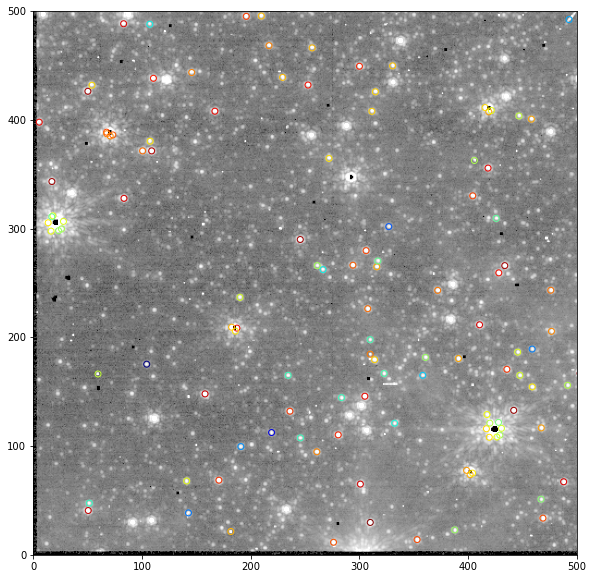

In [61]:
pl.figure(figsize=(12,10))
co = data[:500,:500]
pl.imshow(co, norm=simple_norm(co, stretch='log', min_percent=1, max_percent=99.5), cmap='gray', origin='lower')
sc = pl.scatter(cat['xcentroid'], cat['ycentroid'], c=cat['flux'], norm=simple_norm(cat['flux'], stretch='log'), cmap='jet')
pl.draw()
facecolors = sc.get_facecolors()
sc.set_edgecolors(facecolors)
sc.set_facecolors('none')
pl.axis([0,500,0,500])

In [62]:
from asdf import AsdfFile
import asdf
from astropy import wcs

In [63]:
hdr1 = fits.getheader(f'{output_dir}/jw02221001001_07101_00021_nrca1_cal.fits', ext=('SCI', 1))
hdr2 = fits.getheader(f'{output_dir}/jw02221001001_07101_00022_nrca1_cal.fits', ext=('SCI', 1))
ww1 = wcs.WCS(hdr1)
ww2 = wcs.WCS(hdr2)
gwcs1 = asdf.open(f'{output_dir}/jw02221001001_07101_00021_nrca1_cal.fits').tree['meta']['wcs'] 
gwcs2 = asdf.open(f'{output_dir}/jw02221001001_07101_00022_nrca1_cal.fits').tree['meta']['wcs'] 
cat1 = Table.read(f'{output_dir}/jw02221001001_07101_00021_nrca1_cal_cat.ecsv')
cat2 = Table.read(f'{output_dir}/jw02221001001_07101_00022_nrca1_cal_cat.ecsv')

2022-09-12 15:01:55,265 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T03:26:32.625' from MJD-BEG.
Set DATE-AVG to '2022-08-28T03:26:59.467' from MJD-AVG.
Set DATE-END to '2022-08-28T03:27:26.309' from MJD-END'.
  warnings.warn(

2022-09-12 15:01:55,268 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.496609 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.635465 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526101258.711 from OBSGEO-[XYZ]'.
  warnings.warn(

2022-09-12 15:01:55,287 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T03:28:41.457' from MJD-BEG.
Set DATE-AVG to '2022-08-28T03:

In [64]:
merged_fn = asn_data['products'][0]['name']
print(merged_fn)

hdrm = fits.getheader(f'{output_dir}/{merged_fn}_i2d.fits', ext=('SCI', 1))
wwm = wcs.WCS(hdrm)
gwcsm = asdf.open(f'{output_dir}/{merged_fn}_i2d.fits').tree['meta']['wcs'] 
catm = Table.read(f'{output_dir}/{merged_fn}_cat.ecsv')
datam = fits.getdata(f'{output_dir}/{merged_fn}_i2d.fits', ext=('SCI', 1))

2022-09-12 15:01:55,669 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T03:10:15.538' from MJD-BEG.
Set DATE-AVG to '2022-08-28T03:20:31.148' from MJD-AVG.
Set DATE-END to '2022-08-28T03:29:35.141' from MJD-END'.
  warnings.warn(



jw02221-o001_t001_nircam_clear-f182m-nrca1-test


In [65]:
skycoord1w = ww1.pixel_to_world(cat1['xcentroid'], cat1['ycentroid'])
skycoord2w = ww2.pixel_to_world(cat2['xcentroid'], cat2['ycentroid'])
skycoordmw = wwm.pixel_to_world(catm['xcentroid'], catm['ycentroid'])

skycoord1g = gwcs1.pixel_to_world(cat1['xcentroid'], cat1['ycentroid'])
skycoord2g = gwcs2.pixel_to_world(cat2['xcentroid'], cat2['ycentroid'])
skycoordmg = gwcsm.pixel_to_world(catm['xcentroid'], catm['ycentroid'])

In [66]:
matches_12, sep_12, _ = skycoord1w.match_to_catalog_sky(skycoords2w, nthneighbor=1)
matches_1m, sep_1m, _ = skycoord1w.match_to_catalog_sky(skycoordsmw, nthneighbor=1)
matches_2m, sep_2m, _ = skycoord2w.match_to_catalog_sky(skycoordsmw, nthneighbor=1)

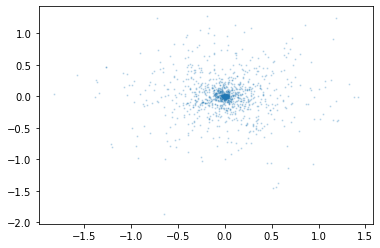

In [67]:
pl.scatter((skycoord1w.ra - skycoordsmw[matches_1m].ra).to(u.arcsec),
           (skycoord1w.dec - skycoordsmw[matches_1m].dec).to(u.arcsec),
           s=1, alpha=0.2,
          )

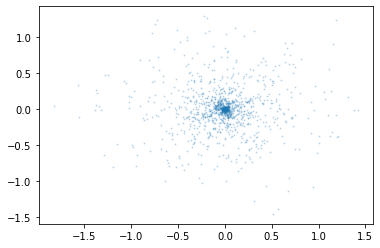

In [68]:
pl.scatter((skycoord2w.ra - skycoordsmw[matches_2m].ra).to(u.arcsec),
           (skycoord2w.dec - skycoordsmw[matches_2m].dec).to(u.arcsec),
           s=1, alpha=0.2,
          )

(-0.5, 0.25, -0.5, 0.5)

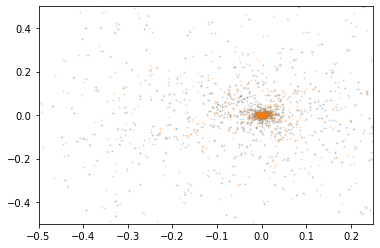

In [69]:
pl.scatter((skycoord1w.ra - skycoordsmw[matches_1m].ra).to(u.arcsec),
           (skycoord1w.dec - skycoordsmw[matches_1m].dec).to(u.arcsec),
           s=1, alpha=0.2,
          )

pl.scatter((skycoord2w.ra - skycoordsmw[matches_2m].ra).to(u.arcsec),
           (skycoord2w.dec - skycoordsmw[matches_2m].dec).to(u.arcsec),
           s=1, alpha=0.2,
          )
pl.axis([-0.5,0.25,-0.5,0.5])

In [70]:
len(slimmed_members)
len(asn_data['products'][0]['members'])

6

In [71]:
import regions
from astropy.coordinates import SkyCoord
import warnings
nrca1reg = regions.RectangleSkyRegion(SkyCoord("17:46:05.99", "-28:44:53.2353160826", frame='icrs', unit=(u.h, u.deg)), width=3*u.arcsec, height=3*u.arcsec)

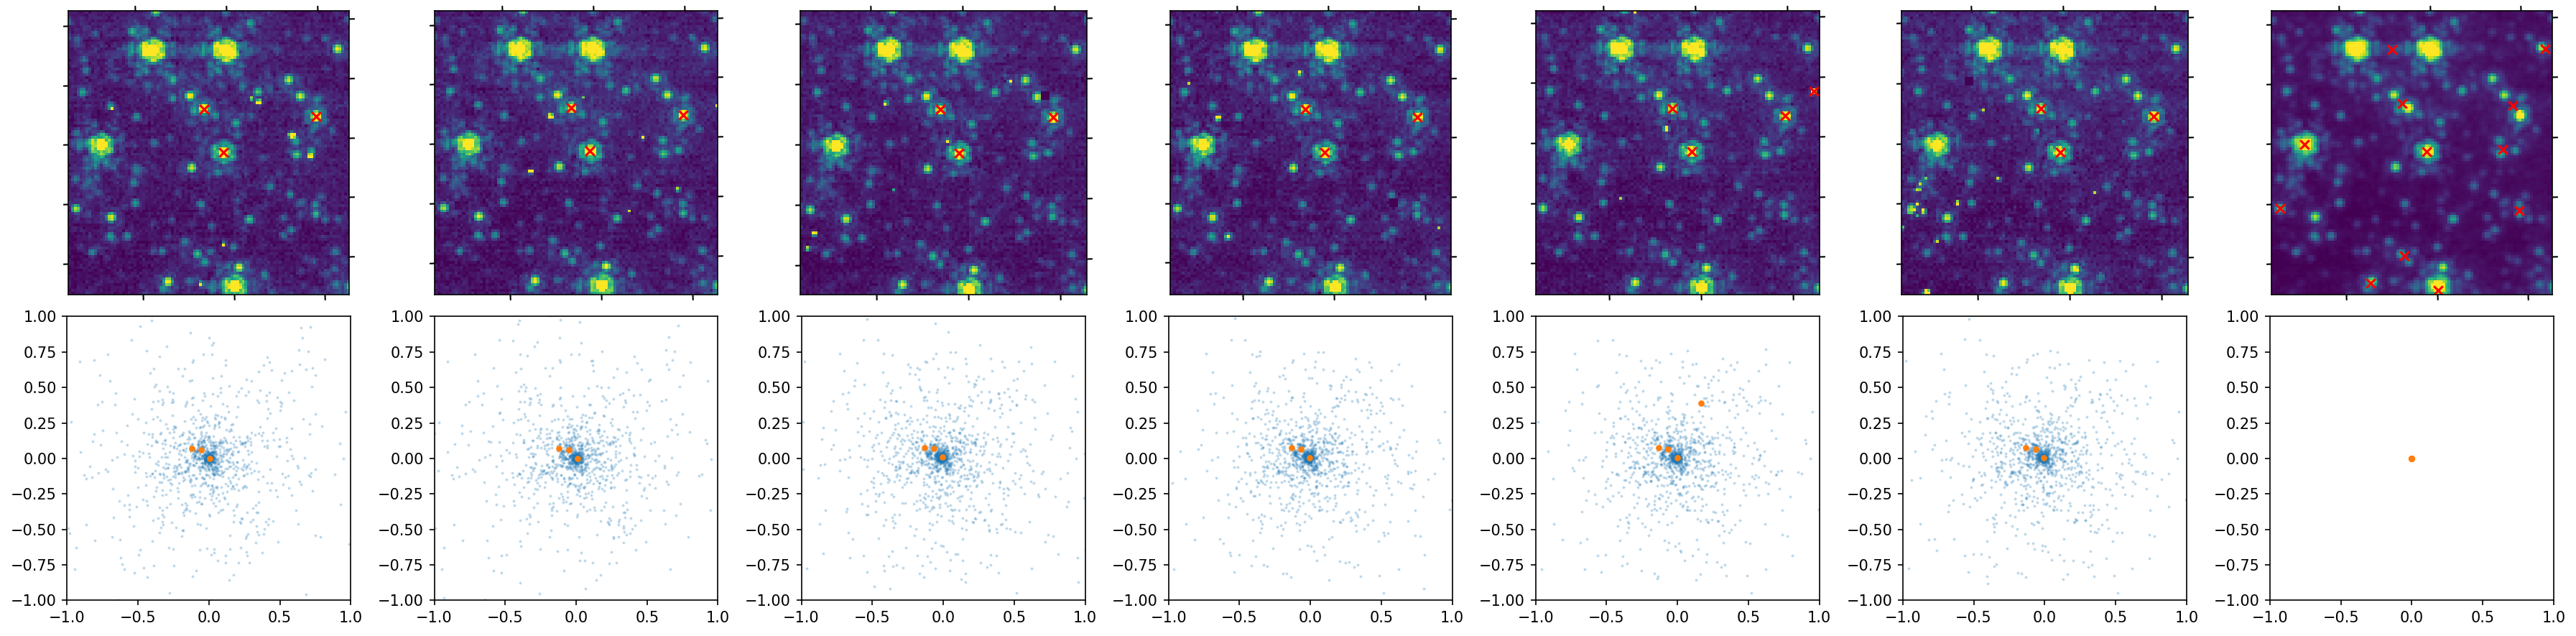

In [72]:
warnings.simplefilter('ignore')
pl.figure(figsize=(24,6), dpi=150)
for ii, fn in enumerate([x['expname'] for x in asn_data['products'][0]['members']] + [f'{merged_fn}_i2d.fits']):
    hdr = fits.getheader(f'{output_dir}/{fn}', ext=('SCI', 1))
    data = fits.getdata(f'{output_dir}/{fn}', ext=('SCI', 1))
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ww = wcs.WCS(hdr)
    with asdf.open(f'{output_dir}/{fn}') as af:
        gwcs = af.tree['meta']['wcs'] 
    
    cat = Table.read(f'{output_dir}/{fn}'.replace('.fits', '_cat.ecsv').replace('_i2d_cat.ecsv', '_cat.ecsv'))
    slcs,_ = nrca1reg.to_pixel(ww).to_mask().get_overlap_slices(data.shape)
    
    skycoordw = ww.pixel_to_world(cat['xcentroid'], cat['ycentroid'])
    skycoordg = gwcs.pixel_to_world(cat['xcentroid'], cat['ycentroid'])
    matches, sep, _ = skycoordg.match_to_catalog_sky(skycoordsmw, nthneighbor=1)
    
    ax = pl.subplot(2,7,ii+1, projection=ww[slcs])
    ax.imshow(data[slcs], norm=simple_norm(data[slcs], min_percent=1, max_percent=99, stretch='asinh'))
    incl = ww[slcs].footprint_contains(skycoordg)
    if incl.any():
        ax.scatter(skycoordg.ra[incl], skycoordsg[incl].dec, transform=ax.get_transform('world'), marker='x', color='r')
    else:
        print("No matches, _yikes_")
    
    ax2 = pl.subplot(2,7,ii+8)
    ax2.scatter((skycoordg.ra - skycoordsmw[matches].ra).to(u.arcsec),
                (skycoordg.dec - skycoordsmw[matches].dec).to(u.arcsec),
                s=1, alpha=0.2,
               )
    ax2.scatter((skycoordg.ra - skycoordsmw[matches].ra).to(u.arcsec)[incl],
                (skycoordg.dec - skycoordsmw[matches].dec).to(u.arcsec)[incl],
                s=10, alpha=1,
               )
    ax2.set_aspect(1)
    ax2.axis([-1, 1, -1, 1])
pl.tight_layout()

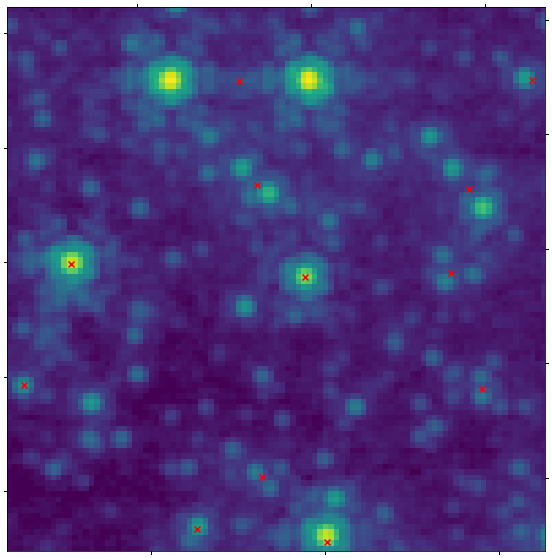

In [73]:
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=ww[slcs])
ax.imshow(datam[slcs], norm=simple_norm(datam[slcs], min_percent=1, max_percent=99.99, stretch='log'), origin='lower')

incl = ww[slcs].footprint_contains(skycoordg)
if incl.any():
    ax.scatter(skycoordg.ra[incl], skycoordsg[incl].dec, transform=ax.get_transform('world'), marker='x', color='r')

In [74]:
ls -lht $output_dir/*cat*

-rw-r--r-- 1 adamginsburg adamginsburg 5.5M Sep 12 14:56 /orange/adamginsburg/jwst/brick/F182M/pipeline//jw02221-o001_t001_nircam_clear-f182m-nrca1-test_cat.ecsv
-rw-r--r-- 1 adamginsburg adamginsburg 117K Sep 12 14:50 /orange/adamginsburg/jwst/brick/F182M/pipeline//jw02221001001_07101_00019_nrca1_cal_cat.ecsv
-rw-r--r-- 1 adamginsburg adamginsburg 117K Sep 12 14:50 /orange/adamginsburg/jwst/brick/F182M/pipeline//jw02221001001_07101_00017_nrca1_cal_cat.ecsv
-rw-r--r-- 1 adamginsburg adamginsburg 117K Sep 12 14:50 /orange/adamginsburg/jwst/brick/F182M/pipeline//jw02221001001_07101_00020_nrca1_cal_cat.ecsv
-rw-r--r-- 1 adamginsburg adamginsburg 117K Sep 12 14:50 /orange/adamginsburg/jwst/brick/F182M/pipeline//jw02221001001_07101_00015_nrca1_cal_cat.ecsv
-rw-r--r-- 1 adamginsburg adamginsburg 117K Sep 12 14:50 /orange/adamginsburg/jwst/brick/F182M/pipeline//jw02221001001_07101_00021_nrca1_cal_cat.ecsv
-rw-r--r-- 1 adamginsburg adamginsburg 117K Sep 12 14:50 /orange/adamginsburg/jwst/brick